In [44]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

In [45]:
data_path = 'out_data'

In [46]:
# function to get the label from the file name
def get_label_from_filename(filename):
    label = filename.split('-')[0]
    return label

In [47]:
# load the files into a dataframe
def load_files_to_dataframe(data_path):
    data = []
    for filename in os.listdir(data_path):
        label = get_label_from_filename(filename)
        image_path = os.path.join(data_path, filename)
        image = Image.open(image_path)
        data.append({'image': image, 'label': label,})
    return pd.DataFrame(data)

In [48]:
df = load_files_to_dataframe(data_path)
print(df.head(20))

                                                image          label
0   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7037206100022
1   <PIL.PngImagePlugin.PngImageFile image mode=RG...           4196
2   <PIL.PngImagePlugin.PngImageFile image mode=RG...          94011
3   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7020097009819
4   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7037203626563
5   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7039610000318
6   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7038010009457
7   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7044610874661
8   <PIL.PngImagePlugin.PngImageFile image mode=RG...           4196
9   <PIL.PngImagePlugin.PngImageFile image mode=RG...          94011
10  <PIL.PngImagePlugin.PngImageFile image mode=RG...  7048840205868
11  <PIL.PngImagePlugin.PngImageFile image mode=RG...  7020097009819
12  <PIL.PngImagePlugin.PngImageFile image mode=RG...  7040913336684
13  <PIL.PngImagePlugin.PngImageFi

In [50]:
# split into train and test sets for X and Y 

X = df['image']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Efficientnet

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [52]:
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        img = img.resize(target_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        processed_images.append(img_array)
    return np.array(processed_images)

In [53]:
X_train_processed = preprocess_images(X_train)
X_test_processed = preprocess_images(X_test)

In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Number of classes
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 26
Classes: ['4011' '4015' '4088' '4196' '7020097009819' '7020097026113'
 '7023026089401' '7035620058776' '7037203626563' '7037206100022'
 '7038010009457' '7038010013966' '7038010021145' '7038010054488'
 '7038010068980' '7039610000318' '7040513000022' '7040513001753'
 '7040913336684' '7044610874661' '7048840205868' '7071688004713'
 '7622210410337' '90433917' '90433924' '94011']


In [55]:
def create_model(num_classes):
    # Load EfficientNetB0 with pre-trained weights (excluding top layers)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [56]:
model = create_model(num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    'efficientnet_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [58]:
history = model.fit(
    X_train_processed,
    y_train_encoded,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5408 - loss: 1.7845
Epoch 1: val_accuracy improved from -inf to 0.92871, saving model to efficientnet_best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5439 - loss: 1.7731 - val_accuracy: 0.9287 - val_loss: 0.2729
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9747 - loss: 0.1604
Epoch 2: val_accuracy improved from 0.92871 to 0.95568, saving model to efficientnet_best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - accuracy: 0.9746 - loss: 0.1602 - val_accuracy: 0.9557 - val_loss: 0.1555
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9890 - loss: 0.0776
Epoch 3: val_accuracy improved from 0.95568 to 0.97495, saving model to efficientnet_best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.9890 - loss: 0.0775 - val_accuracy: 0.9750 - val_loss: 0.1175
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9944 - loss: 0.0449
Epoch 4: val_accuracy improved from 0.97495 to 0.97688, saving model to efficientnet_best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.9944 - loss: 0.0449 - val_accuracy: 0.9769 - val_loss: 0.0923
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9999 - loss: 0.0253
Epoch 5: val_accuracy did not improve from 0.97688
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - accuracy: 0.9999 - loss: 0.0253 - val_accuracy: 0.9769 - val_loss: 0.0900
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9988 - loss: 0.0216
Epoch 6: val_accuracy improved from 0.97688 to 0.97881, saving model to efficientnet_best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.9988 - loss: 0.0216 - val_accuracy: 0.9788 - val_loss: 0.0849
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 1.0000 - loss: 0.0131
Epoch 7: val_accuracy did not improve from 0.97881
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 333ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.9730 - val_loss: 0.0850
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 1.0000 - loss: 0.0115
Epoch 8: val_accuracy did not improve from 0.97881
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9750 - val_loss: 0.0910
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 9: val_accuracy did not improve from 0.97881
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9788 - val_loss: 0.0828
Epoch 10/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 10: val_accuracy did not

In [59]:
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9784 - loss: 0.0688
Test accuracy: 0.9769
Test loss: 0.0681


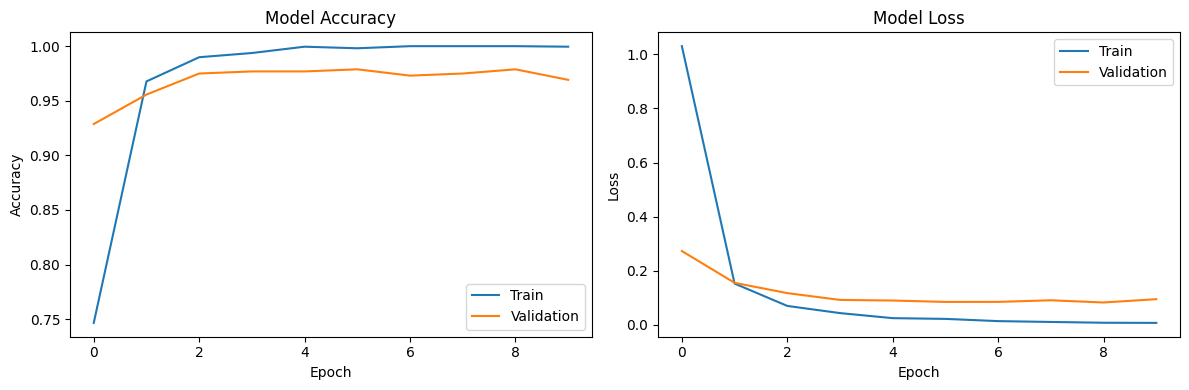

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [61]:
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step


In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

         4011       1.00      1.00      1.00        29
         4015       0.94      1.00      0.97        46
         4088       1.00      1.00      1.00        29
         4196       1.00      0.96      0.98        48
7020097009819       1.00      1.00      1.00        35
7020097026113       1.00      1.00      1.00        14
7023026089401       1.00      1.00      1.00        22
7035620058776       1.00      1.00      1.00         8
7037203626563       1.00      0.92      0.96        12
7037206100022       1.00      0.96      0.98        27
7038010009457       1.00      1.00      1.00        16
7038010013966       0.97      1.00      0.99        35
7038010021145       0.95      1.00      0.97        18
7038010054488       1.00      1.00      1.00        26
7038010068980       1.00      1.00      1.00        41
7039610000318       0.96      1.00      0.98        22
7040513000022       0.91      1.00      0.95        20
704051300

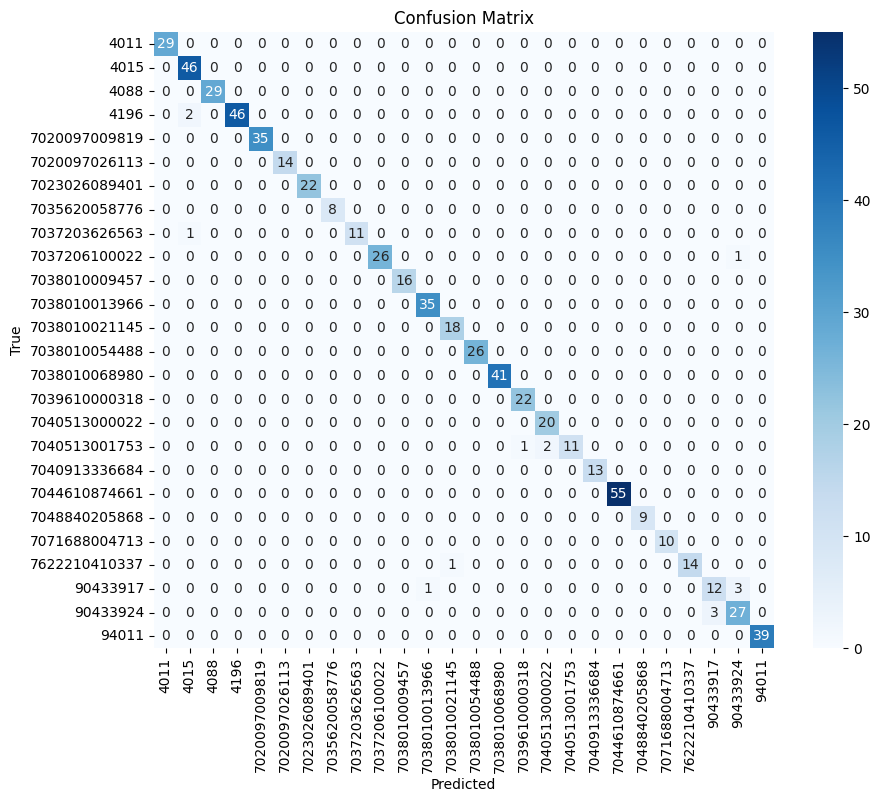

In [65]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()